# Построение ML-продукта для предсказания повторной покупки покупателя
**Описание проекта**
<br>Предоставлено три файла - каждый файл это отдельный интернет-магазин:
- `marketplace` – мультикатегорийный магазин с посещаемостью более 8-ми млн сессий в месяц, 
- `apparel` – магазин одежды, по характеристикам похожий на маркетплейс, 
- `gifts` - очень маленький магазин подарков.

<br>В данных - обезличенная история покупок клиентов за определенный период.

**Цель проекта**
- Необходимо создать решение для предсказания совершения покупателем повторной покупки в течение ближайших 30-ти дней 

**Задачи**
- Необходимо выбрать и обосновать метрику (Заказчику важен положительный класс покупателей),
- предложить решение, способное с высокой вероятностью предсказывать поведение клиентов.

**Ход исследования**
- загрузка данных и ознакомление с ними,
- EDA,
- создание новых признаков (при необходимости),
- отбор финального набора обучающих признаков,
- подготовка данных для обучения,
- выбор и обучение моделей (разных архитектур),
- оценка качества предсказания лучшей модели на тестовой выборке,
- анализ важности признаков лучшей модели,
- отчёт по проведённому исследованию.

**Описание данных**
<br>`client_id` - идентификатор клиента,
<br>`quantity` - количество товара в заказе,
<br>`price` - цена единицы товара в заказе,
<br>`message_id` - идентификатор сообщения из рассылки,
<br>`date` - дата покупки

**Выбор метрик**
- данная задача является задачей классификации,
  <br>ориентированная на временные ряды,
- метрики для оптимизации будут выбраны после ознакомления с данными,
- предварительно - `ROC-AUC`

## Настройка рабочей среды

In [1]:
# !pip list
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install pyarrow
# !pip install phik
# !pip install statsmodels
# !pip install scikit-learn
# !pip install prophet
# !pip install ipywidgets plotly
# !pip install catboost

In [2]:
import random
import numpy as np
import pandas as pd

### Импорт своего класса

In [3]:
from research_class import DatasetExplorer

Установка констант

In [4]:
RANDOM_STATE = 42

Установка random_state

In [5]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## Загрузка и первичный EDA

In [6]:
try:
    marketplace = pd.read_csv('data/marketplace-purchases.csv', parse_dates=['date', 'created_at'])
    apparel = pd.read_csv('data/apparel-purchases.csv', parse_dates=['date'])
    gifts = pd.read_csv('data/gifts-purchases.csv', parse_dates=['date'])
    h22 = pd.read_csv('data/holidays_calendar_2022.csv')
    h23 = pd.read_csv('data/holidays_calendar_2023.csv')
    print('загружено из каталога "data"')
except:
    marketplace = pd.read_csv(userdata.get('marketplace_path'), parse_dates=['date', 'created_at'])
    apparel = pd.read_csv(userdata.get('apparel_path'), parse_dates=['date'])
    gifts = pd.read_csv(userdata.get('gifts_path'), parse_dates=['date'])
    h22 = pd.read_csv(userdata.get('h22_path'))
    h23 = pd.read_csv(userdata.get('h23_path'))
    print('загружено из каталога Google Drive')

загружено из каталога "data"


### Holidays

In [7]:
def date_preparation(data, year):
    '''
    - на вход принимает датасет с праздниками и год этого датасета
    - возвращает обработанный датасет
    '''
    data = data.reset_index(drop=True).T[:13]
    data = data.set_axis(data.iloc[0], axis=1)[1:]
    data.insert(0, 'month', range(1, len(data) + 1))
    data.insert(0, 'year', year)
    data = data.replace(['\+', '\*'], '', regex=True)
    data[year] = data[year].str.split(',')
    data = data.explode(year)
    data = data.rename(columns={year: 'day'})
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
    
    return data

In [8]:
h22 = date_preparation(h22, 2022)
h23 = date_preparation(h23, 2023)
holidays = pd.concat([h22, h23], ignore_index=True)
holidays.sample(5)

Год/Месяц,year,month,day,date
24,2022,2,27,2022-02-27
6,2022,1,7,2022-01-07
152,2023,3,18,2023-03-18
209,2023,9,17,2023-09-17
237,2023,12,17,2023-12-17


#### Выводы и наблюдения
- подготовлен датасет, в котором перечислены все выходные и праздничные дни в РФ в 2022 и 2023 годах

### Marketplace

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   48182 non-null  int64         
 1   quantity    48182 non-null  int64         
 2   price       48182 non-null  float64       
 3   message_id  48182 non-null  object        
 4   created_at  48182 non-null  datetime64[ns]
 5   date        48182 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 2.2+ MB


,client_id,quantity,price,message_id,created_at,date
38957,1515915625520049365,1,58798.0,1515915625520049365-1561-63f5b21423c41,2023-02-22,2023-02-22 07:54:26
17593,1515915625533002613,1,6299.0,1515915625517580463-1596-640181a7da72a,2023-03-03,2023-03-03 06:52:27
29253,1515915625559756457,1,130998.0,1515915625519524273-2034-64d9fe880cc04,2023-08-14,2023-08-14 13:52:07
1219,1515915625470243155,1,4108.0,1515915625470243155-2100-6501b27795027,2023-09-14,2023-09-14 10:14:26
6432,1515915625497262383,1,7198.0,1515915625497262383-1244-6367468693386,2022-11-07,2022-11-07 09:58:39


количество полных дубликатов строк: 2159


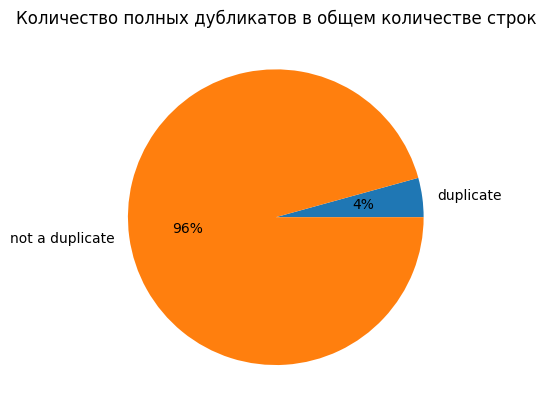

количество уникальных значений client_id:
		17787
количество уникальных значений client_id в общем количестве client_id:
		36.916%


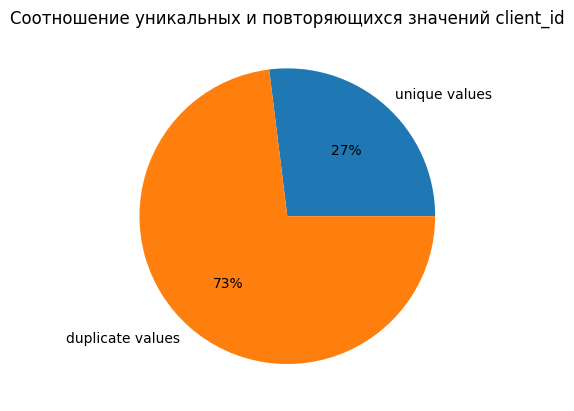

количество уникальных значений message_id:
		20940
количество уникальных значений message_id в общем количестве message_id:
		43.460%


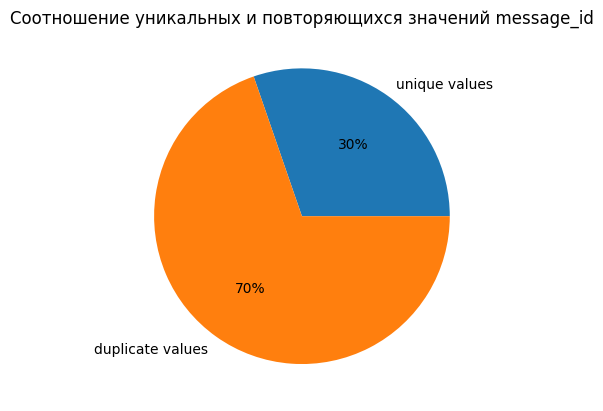

описание quantity:
		count    48182.000000
mean         1.017413
std          0.540592
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         50.000000
Name: quantity, dtype: float64
количество уникальных значений quantity: 15


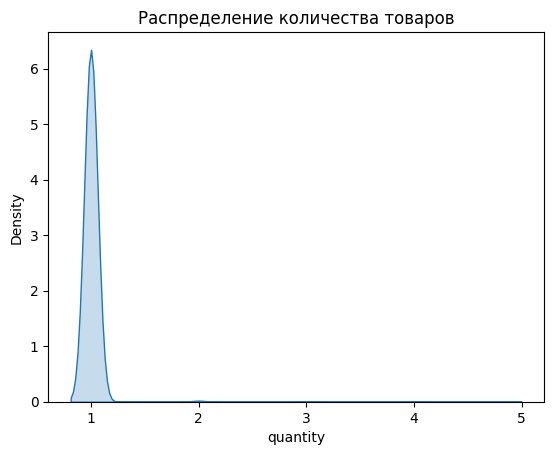

описание price:
		count    4.818200e+04
mean     2.791895e+04
std      4.492274e+04
min      0.000000e+00
25%      1.204250e+03
50%      9.998000e+03
75%      3.599800e+04
max      1.299998e+06
Name: price, dtype: float64
количество уникальных значений price: 4991


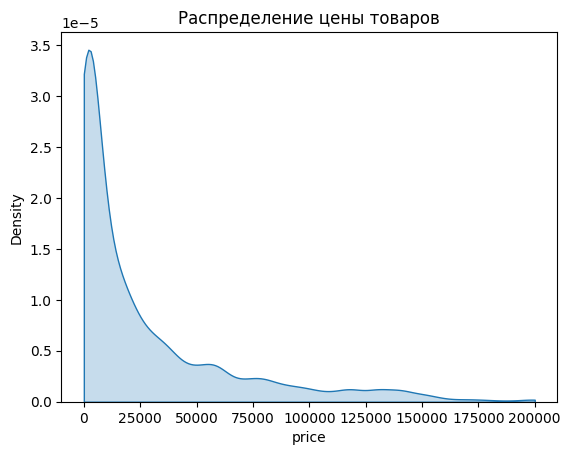

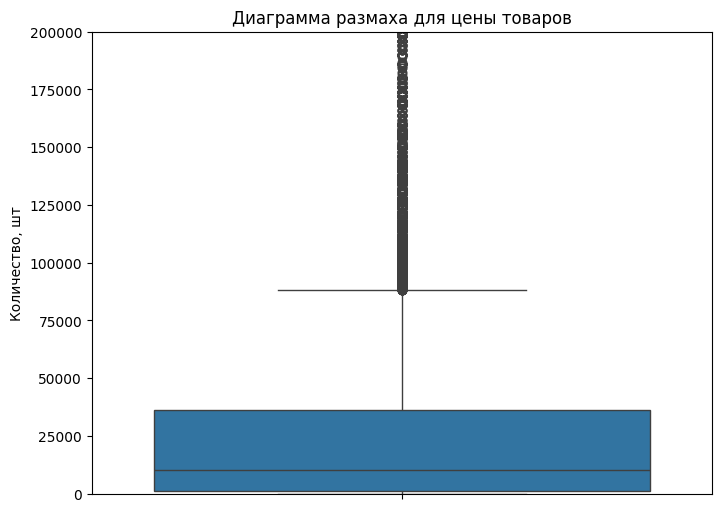

Первая запись в датафрейме: 2022-10-26 08:35:46
		Последняя запись в датафрейме: 2023-10-26 13:34:11


In [9]:
explorer_marketplace = DatasetExplorer(marketplace, y_lim=200000)
explorer_marketplace.explore_dataset()  # 48182

In [10]:
print(f"""Количество совпадений в признаках created_at и date по отношению ко всему датафрейму:
{(marketplace['created_at'] == marketplace['date'].dt.date).sum() / marketplace.shape[0] * 100:.0f}%""")

Количество совпадений в признаках created_at и date по отношению ко всему датафрейму:
100%


Удаление дублирующего признака

In [11]:
marketplace = marketplace.drop(['date'], axis=1)

Переименование признака для единообразия

In [12]:
marketplace.rename(columns={'created_at': 'date'}, inplace=True)

#### Выводы и наблюдения
- пропусков в данных не обнаружено;
- количество полных дубликатов строк составляет около 5% от датафрейма,
  <br>но нет понимания - действительно ли это дубликаты (возможно - нусколько товаров
  <br>из одной категории, но сразными артикулами, принимаю решение оставить их
  <br>и использовать в дальнейшем при агрегации;
- количество уникальных значений `client_id` составляет чуть больше трети от всех,
  <br>что свидетельствует о повторных действиях клиентов;
-  медиана и среднее в `quantity` практически равны, что говорит о нормальности распределения;
-  в признаке `price` среднее значение больше медианного, наблюдается правосторонняя асимметрия,
  <br>распределение отличается от нормального;
- в признаке `price`обнаружено большое количество выбросов, удалять их нет необходимости,
  <br>т.к. они помогут в дальнейшем исследовании;
- период записей в датафрейме - 1 год (с 26.10.22 по 26.10.23);
- признаки `created_at` и `date` полностью совпадают, принимаю решение удалить `date`,
  <br>посколько собираюсь агрегировать покупки по каждому клиенту за день, т.к. Заказчика интересует
  <br>возвращение клиента через дни, а не часы.

### Apparel

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   client_id       133104 non-null  int64         
 1   quantity        133104 non-null  int64         
 2   price           133104 non-null  float64       
 3   date            133104 non-null  datetime64[ns]
 4   message_id      133104 non-null  object        
 5   recommended_by  133104 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.1+ MB


,client_id,quantity,price,date,message_id,recommended_by
102111,1515915625966130065,1,210.0,2023-08-04,1515915625966130065-13598-64cd08bcf10da,bulk_message
115476,1515915625764066035,1,346.0,2022-12-23,1515915625764066035-5286-62c52c0348b65,bulk_message
100772,1515915625764187190,1,2499.0,2023-06-29,1515915625764187190-13406-649aaef97a8c2,bulk_message
122255,1515915625817356226,1,2563.0,2022-11-26,1515915625817356226-8169-6381ebc51689f,bulk_message
82710,1515915625559323786,1,199.0,2023-06-28,1515915625776574312-13406-649aafca60b77,bulk_message


количество полных дубликатов строк: 59250


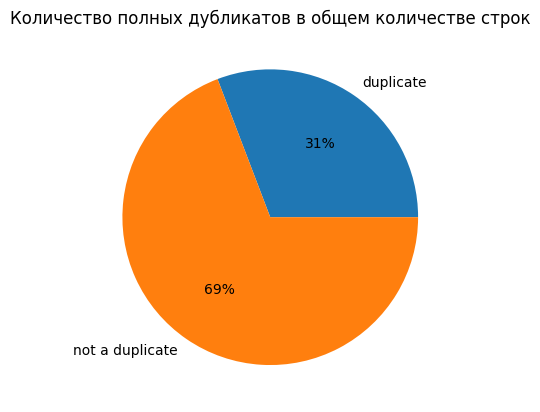

количество уникальных значений client_id:
		28891
количество уникальных значений client_id в общем количестве client_id:
		21.706%


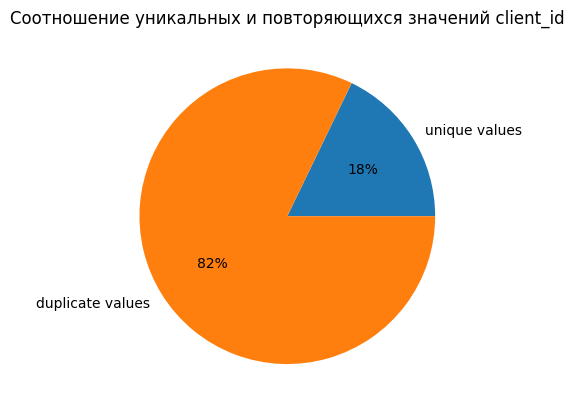

количество уникальных значений message_id:
		25426
количество уникальных значений message_id в общем количестве message_id:
		19.102%


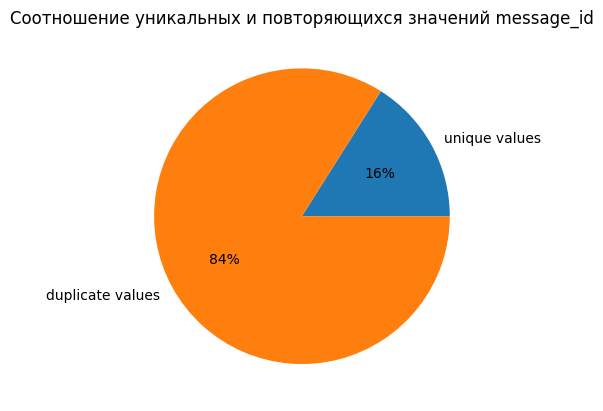

описание quantity:
		count    133104.000000
mean          1.004312
std           0.149315
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64
количество уникальных значений quantity: 12


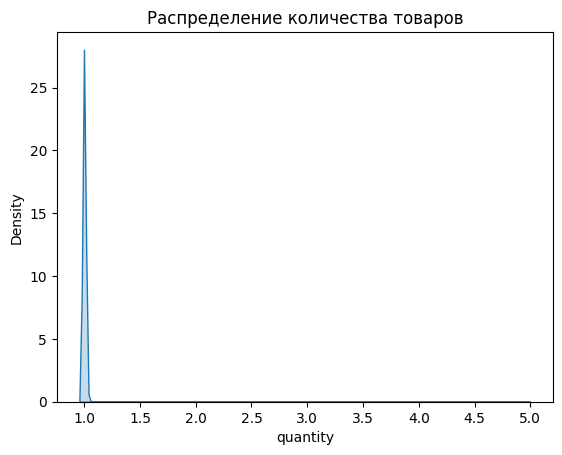

описание price:
		count    133104.000000
mean       1110.433067
std        1257.080854
min           1.000000
25%         280.000000
50%         799.000000
75%        1499.000000
max       63499.000000
Name: price, dtype: float64
количество уникальных значений price: 3335


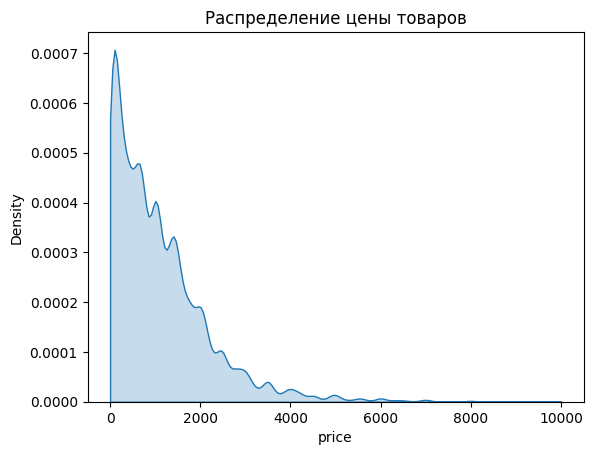

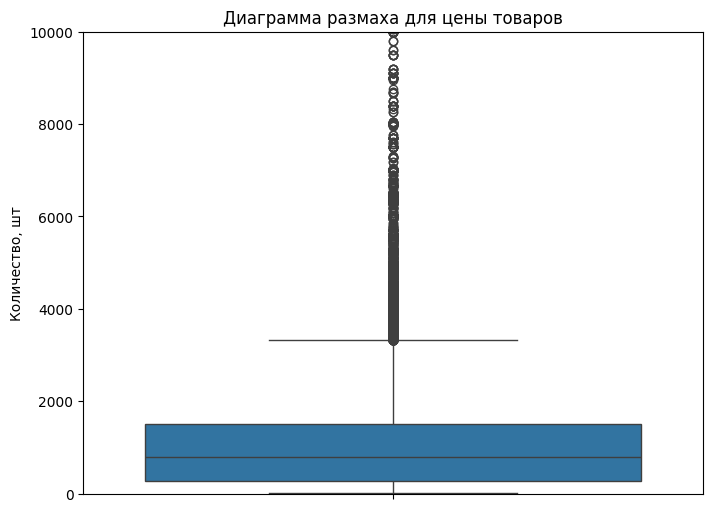

Первая запись в датафрейме: 2022-10-26 00:00:00
		Последняя запись в датафрейме: 2023-10-26 00:00:00


In [13]:
explorer_apparel = DatasetExplorer(apparel, y_lim=10000)
explorer_apparel.explore_dataset()  # 133104

In [14]:
print(f"""уникальные значения recommended_by:
{apparel['recommended_by'].value_counts().sort_index(ascending=False)}""")

уникальные значения recommended_by:
recommended_by
bulk_message    133104
Name: count, dtype: int64


Удаление признака recommended_by

In [15]:
apparel = apparel.drop(['recommended_by'], axis=1)

#### Выводы и наблюдения
- пропусков в данных не обнаружено;
- количество полных дубликатов строк составляет около 30% от датафрейма,
  <br>но нет понимания - действительно ли это дубликаты (возможно - нусколько товаров
  <br>из одной категории, но сразными артикулами, принимаю решение оставить их
  <br>и использовать в дельнейшем при агрегации;
- количество уникальных значений `client_id` составляет около 20% от всех,
  <br>что свидетельствует о повторных действиях клиентов;
- медиана и среднее в `quantity` практически равны, что говорит о нормальности распределения;
- в признаке `price` среднее значение больше медианного, наблюдается правосторонняя асимметрия,
  <br>распределение отличается от нормального;
- в признаке `price` обнаружено большое количество выбросов, удалять их нет необходимости,
  <br>т.к. они помогут в дальнейшем исследовании;
- период записей в датафрейме - 1 год (с 26.10.22 по 26.10.23);
- в признаке `recommended_by` только одно значение, принимаю решение удалить данный признак,
  <br>как неинформативный.

### Gifts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       811 non-null    int64         
 1   quantity        811 non-null    int64         
 2   price           811 non-null    float64       
 3   date            811 non-null    datetime64[ns]
 4   message_id      811 non-null    object        
 5   recommended_by  811 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 38.1+ KB


,client_id,quantity,price,date,message_id,recommended_by
804,1515915625869270636,1,1891.0,2022-11-23,1515915625835006252-8044-637ccf9a372d3,bulk_message
429,1515915625853062360,1,49990.0,2023-01-12,1515915625853062360-9331-63c0128a7a5f2,bulk_message
233,1515915625817415471,1,34990.0,2023-03-09,1515915625817415471-10707-6405f1b769dc1,bulk_message
294,1515915625803892965,1,19990.0,2023-05-22,1515915625864123161-12742-646b14f264f93,bulk_message
551,1515915625803180879,1,3073.0,2023-06-29,1515915625951750973-13766-649d8889ee133,bulk_message


количество полных дубликатов строк: 56


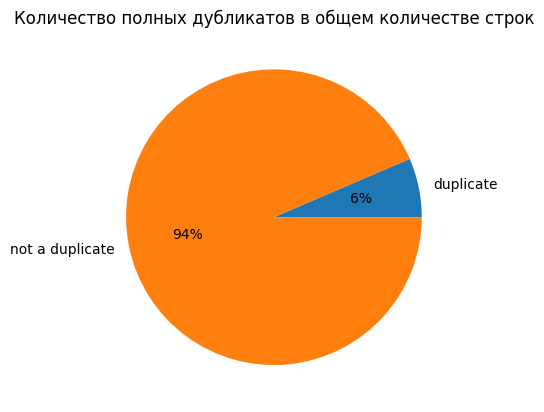

количество уникальных значений client_id:
		326
количество уникальных значений client_id в общем количестве client_id:
		40.197%


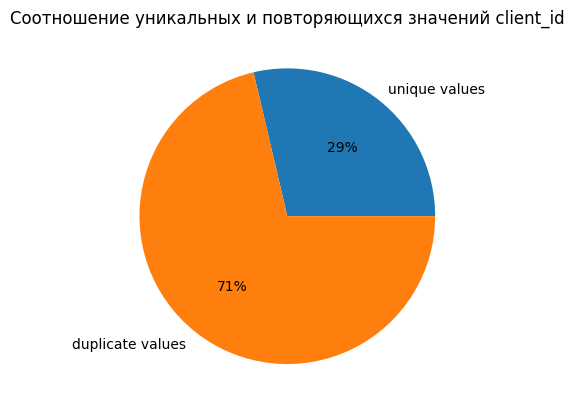

количество уникальных значений message_id:
		342
количество уникальных значений message_id в общем количестве message_id:
		42.170%


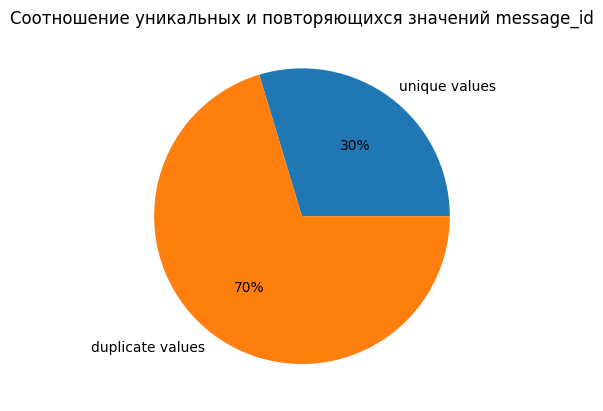

описание quantity:
		count    811.000000
mean       1.003699
std        0.060745
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: quantity, dtype: float64
количество уникальных значений quantity: 2


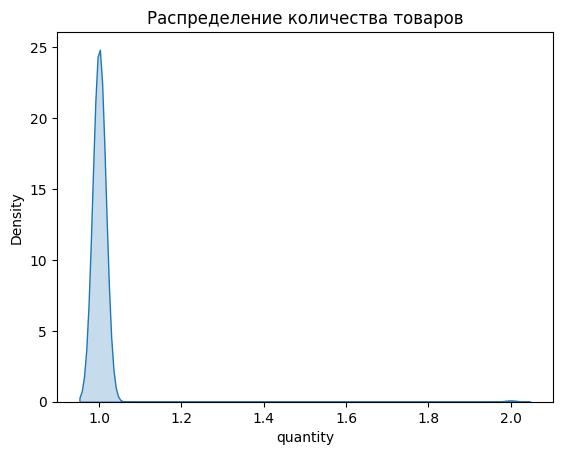

описание price:
		count       811.000000
mean      14468.795314
std       17774.341837
min         656.000000
25%        3878.000000
50%        7533.000000
75%       17938.000000
max      173586.000000
Name: price, dtype: float64
количество уникальных значений price: 598


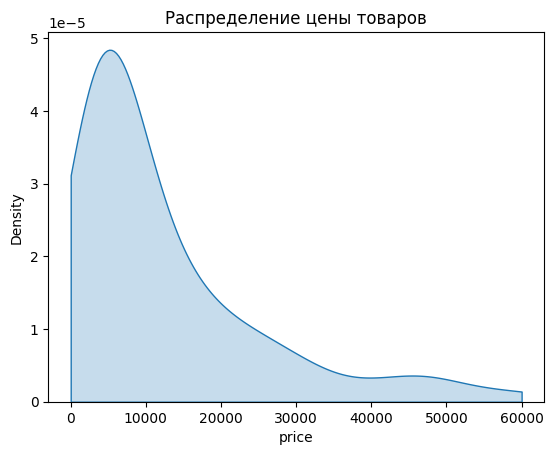

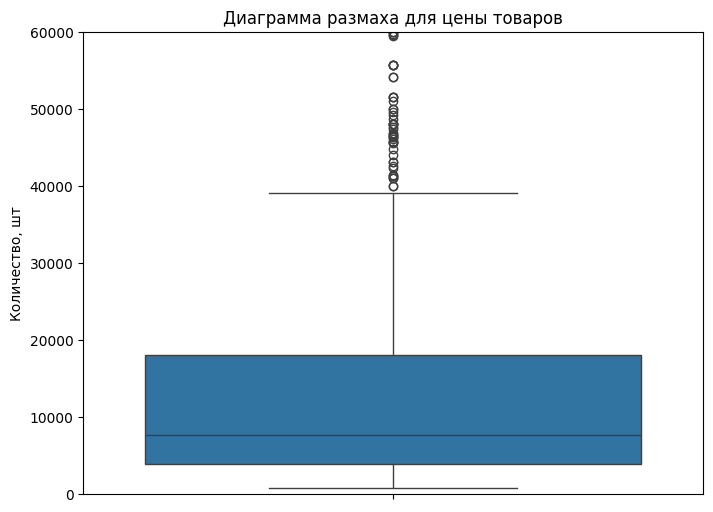

Первая запись в датафрейме: 2022-10-26 00:00:00
		Последняя запись в датафрейме: 2023-10-24 00:00:00


In [16]:
explorer_gifts = DatasetExplorer(gifts, y_lim=60000)
explorer_gifts.explore_dataset()  # 811

In [17]:
print(f"""уникальные значения recommended_by:
{gifts['recommended_by'].value_counts().sort_index(ascending=False)}""")

уникальные значения recommended_by:
recommended_by
bulk_message    811
Name: count, dtype: int64


Удаление признака recommended_by

In [18]:
gifts = gifts.drop(['recommended_by'], axis=1)

#### Выводы и наблюдения
- пропущенных значений в данных не обнаружено;
- количество полных дубликатов строк составляет около 6% от датафрейма,
  <br>но нет понимания - действительно ли это дубликаты (возможно - нусколько товаров
  <br>из одной категории, но сразными артикулами, принимаю решение оставить их
  <br>и использовать в дельнейшем при агрегации;
- количество уникальных значений `client_id` составляет около трети от всех,
  <br>что свидетельствует о повторных действиях клиентов;
- количество уникальных значений `message_id` составляет около трети от всех;
- медиана и среднее в `quantity` практически равны, что говорит о нормальности распределения;
- в признаке `price` среднее значение больше медианного, наблюдается правосторонняя асимметрия,
  <br>распределение отличается от нормального;
- в признаке `price` обнаружено большое количество выбросов, удалять их нет необходимости,
  <br>т.к. они помогут в дальнейшем исследовании;
- период записей в датафрейме - 1 год (с 26.10.22 по 24.10.23);
- в признаке `recommended_by` только одно значение, принимаю решение удалить данный признак,
  <br>как неинформативный.

## Предобработка, создание признаков

### Marketplace

interval columns not set, guessing: ['quantity', 'price', 'target', 'cumulative_sum', 'is_holiday']


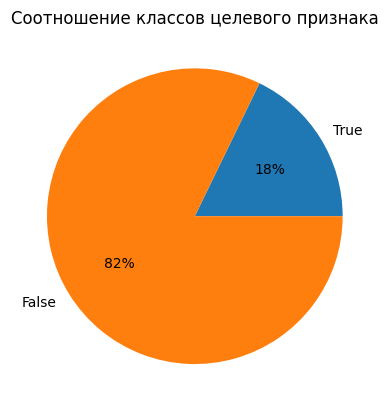

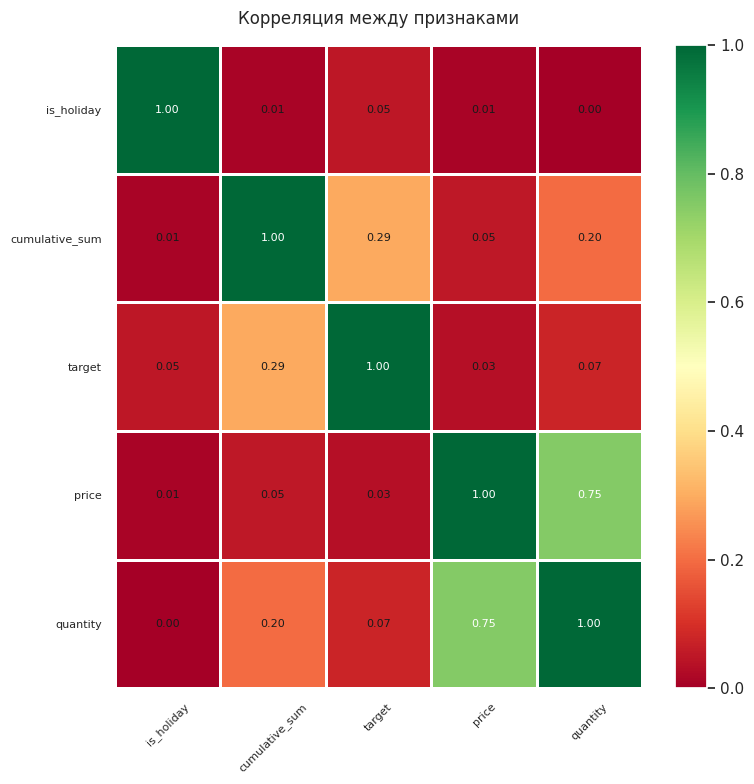

In [19]:
grouped_mp = explorer_marketplace.add_new_features(dataset=marketplace, holidays=holidays)

In [20]:
grouped_mp.info()
grouped_mp.sample(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21716 entries, 2022-10-26 to 2023-10-24
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       21716 non-null  int64  
 1   quantity        21716 non-null  int64  
 2   price           21716 non-null  float64
 3   message_id      21716 non-null  object 
 4   target          21716 non-null  int64  
 5   cumulative_sum  21716 non-null  int64  
 6   is_holiday      21716 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 1.3+ MB


,client_id,quantity,price,message_id,target,cumulative_sum,is_holiday
date,,,,,,,
2023-03-28,1515915625518996037,1,398.0,1515915625518996037-1653-64214e749ca80,0,1,0
2023-07-23,1515915625571462784,1,2998.0,1515915625571462784-1990-64ba4064b3c3d,0,1,1
2022-12-19,1515915625503948136,2,111996.0,1515915625503948136-1399-63a04c579843c15159156...,0,1,0
2023-03-07,1515915625519851864,1,7306.0,1515915625519851864-1605-6405a58cb5eed,0,2,1
2023-03-28,1515915625571102165,4,37992.0,1515915625571102165-1653-64214e8277b9515159156...,0,1,0


### Apparel

interval columns not set, guessing: ['quantity', 'price', 'target', 'cumulative_sum', 'is_holiday']


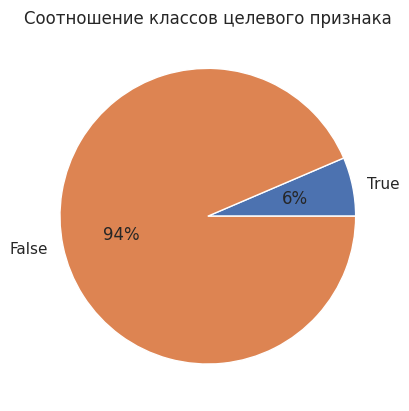

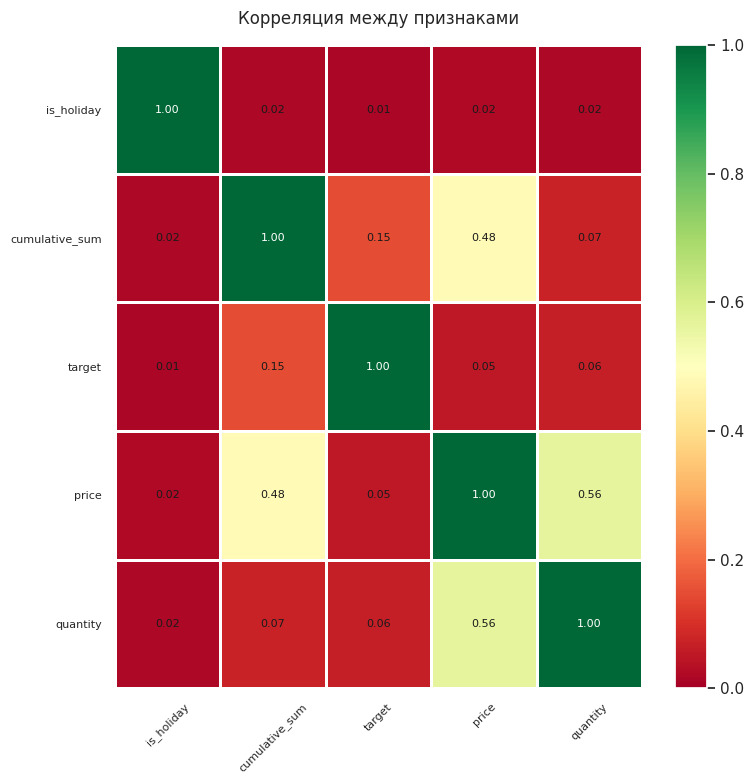

In [21]:
grouped_aprl = explorer_apparel.add_new_features(dataset=apparel, holidays=holidays)

In [22]:
grouped_aprl.info()
grouped_aprl.sample(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32394 entries, 2022-10-26 to 2023-10-24
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       32394 non-null  int64  
 1   quantity        32394 non-null  int64  
 2   price           32394 non-null  float64
 3   message_id      32394 non-null  object 
 4   target          32394 non-null  int64  
 5   cumulative_sum  32394 non-null  int64  
 6   is_holiday      32394 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.0+ MB


,client_id,quantity,price,message_id,target,cumulative_sum,is_holiday
date,,,,,,,
2023-07-04,1515915625982460536,2,798.0,1515915625982460536-13436-64a3a7a38e1ad1515915...,0,1,0
2023-06-09,1515915625932324061,7,1735.0,1515915625932324061-13249-6481b9301f21c1515915...,0,1,0
2022-11-22,1515915625656519600,3,2513.0,1515915625766049461-7879-637487693cc5e15159156...,0,1,0
2023-06-11,1515915625824711642,4,3916.0,1515915625824711642-13157-648318c50d1dc1515915...,0,1,1
2023-04-27,1515915625632645428,6,11194.0,1515915625632645428-12183-64493ea099d7c1515915...,0,1,0


### Gifts

interval columns not set, guessing: ['quantity', 'price', 'target', 'cumulative_sum', 'is_holiday']


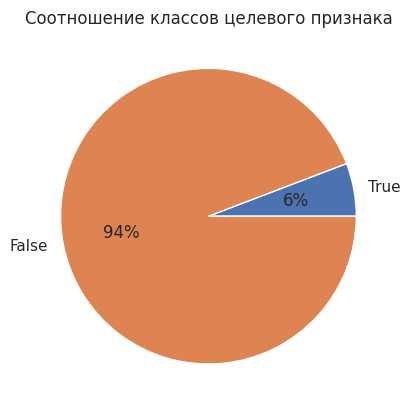

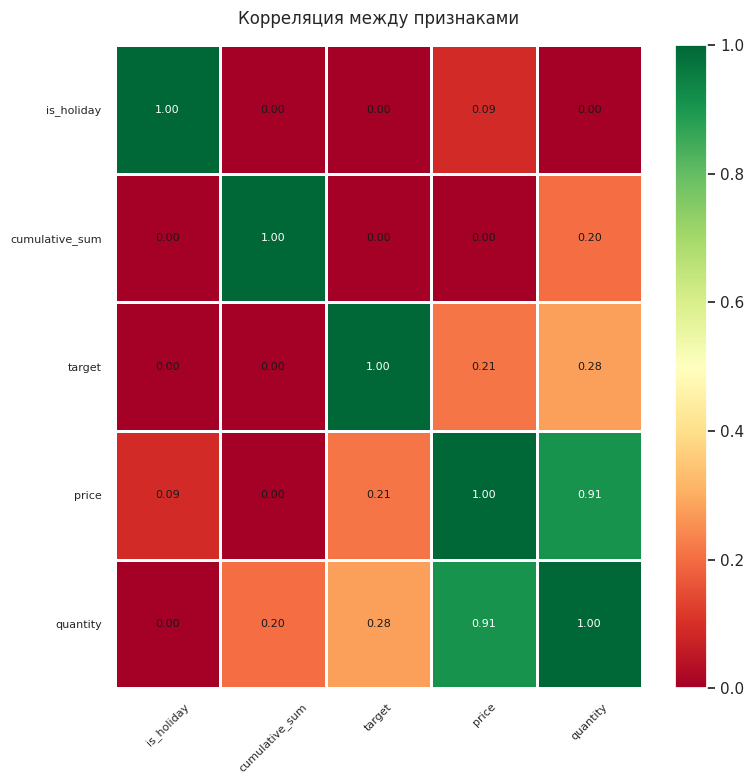

In [23]:
grouped_gft = explorer_gifts.add_new_features(dataset=gifts, holidays=holidays)

In [24]:
grouped_gft.info()
grouped_gft.sample(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345 entries, 2022-10-26 to 2023-09-23
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       345 non-null    int64  
 1   quantity        345 non-null    int64  
 2   price           345 non-null    float64
 3   message_id      345 non-null    object 
 4   target          345 non-null    int64  
 5   cumulative_sum  345 non-null    int64  
 6   is_holiday      345 non-null    int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 21.6+ KB


,client_id,quantity,price,message_id,target,cumulative_sum,is_holiday
date,,,,,,,
2023-09-02,1515915625979592473,2,29359.0,1515915625979592473-15241-64f09c64ef1f91515915...,0,1,1
2023-02-06,1515915625835005526,3,10135.0,1515915625835005526-9844-63dbb9c0bb19815159156...,0,1,0
2023-01-16,1515915625865083837,1,4741.0,1515915625865083837-9389-63c510eca6f2c,0,1,0
2023-05-22,1515915625949117112,5,164198.0,1515915625949117112-12742-646b14f26b8d71515915...,0,1,0
2023-03-21,1515915625803892965,13,222755.0,1515915625864123161-11100-64185f9ab960b1515915...,0,1,0


### Выводы и наблюдения
<br>В каждом датасете
- Произведена группировка по дням и клиентам;
- добавлен целевой признак `target`:
    - если в течение 30-ти дней произведена повторная покупка, то значение = 1
    - если покупки не случилось, то ставим нулевое значение
    - каждая повторная покупка обнуляет отсчёт по клиенту
- добавлен признак `cumulative_sum` кумулятивной суммы активностей в течение 30-ти дней;
- добавлен признак `is_holiday`, обозначающего праздничный или выходной день;
- удалены записи за последние 30 дней, т.к. за этот период нет возможности корректно посчитать таргет;
- установлена дата в индекс, датасет упорядочен по возрастанию;
- наблюдается большой дисбаланс классов;
- проверка корреляций между признаками показала отсутствие зависимостей с целевым признаком,
  <br>в наборе данных `gifts` наблюдается прямая связь между признаками `price` и `quantity`.

## EDA

### Marketplace

Проведение теста Дики-Фуллера для проверки ряда на стационарность
adf:  -9.198043897496502
p-value:  2.037337011354062e-15
Critical values:  {'1%': -3.4306518310347043, '5%': -2.8616733992749053, '10%': -2.566841004690704}
ряд стационарен, единичных корней нет


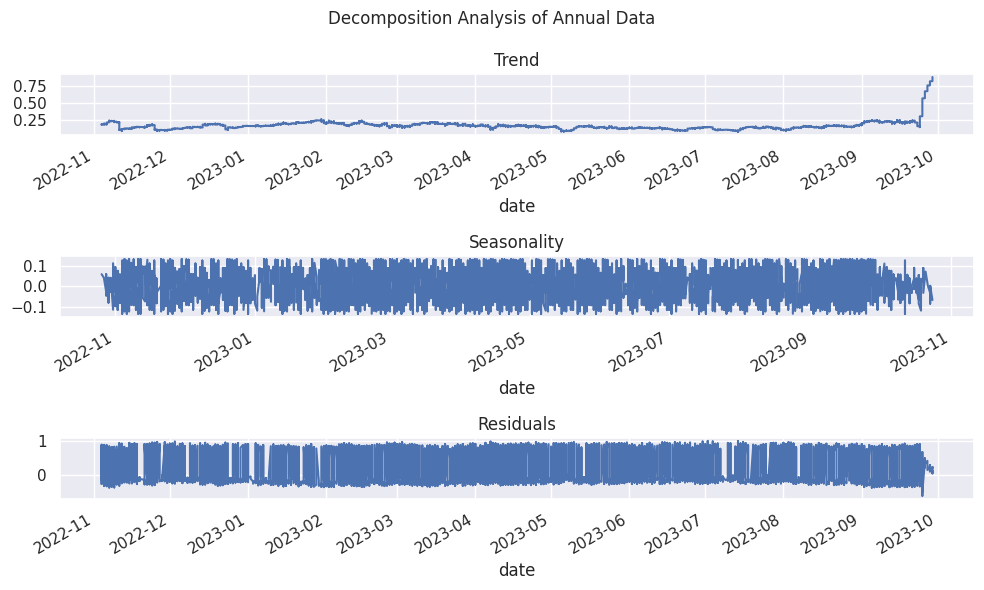

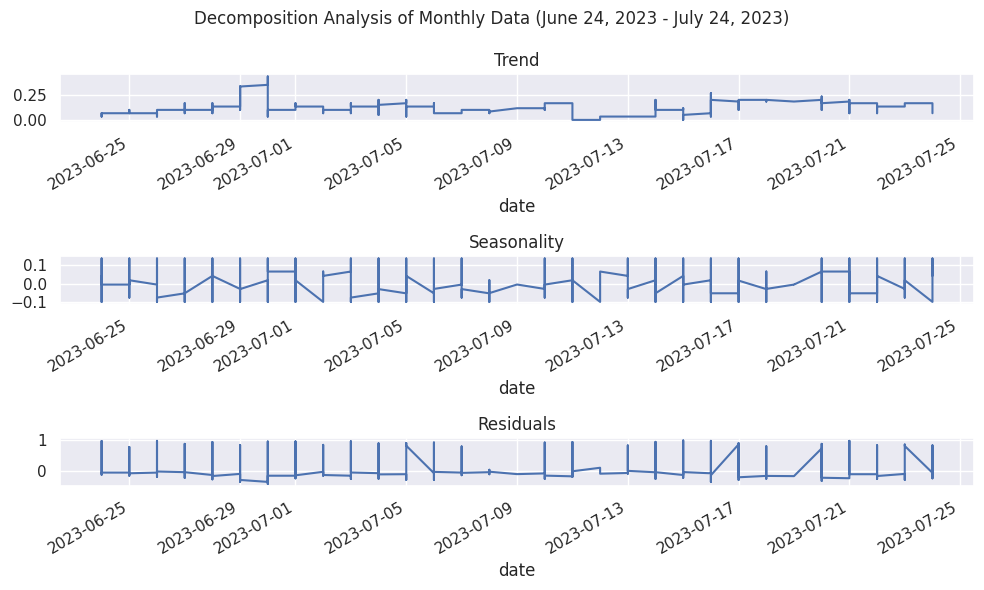

In [25]:
explorer_marketplace.seasonality_and_stationarity(grouped_mp, period_1=365, period_2=30)

### Apparel

Проведение теста Дики-Фуллера для проверки ряда на стационарность
adf:  -23.104647857486334
p-value:  0.0
Critical values:  {'1%': -3.4305521082525106, '5%': -2.8616293266236132, '10%': -2.5668175457942413}
ряд стационарен, единичных корней нет


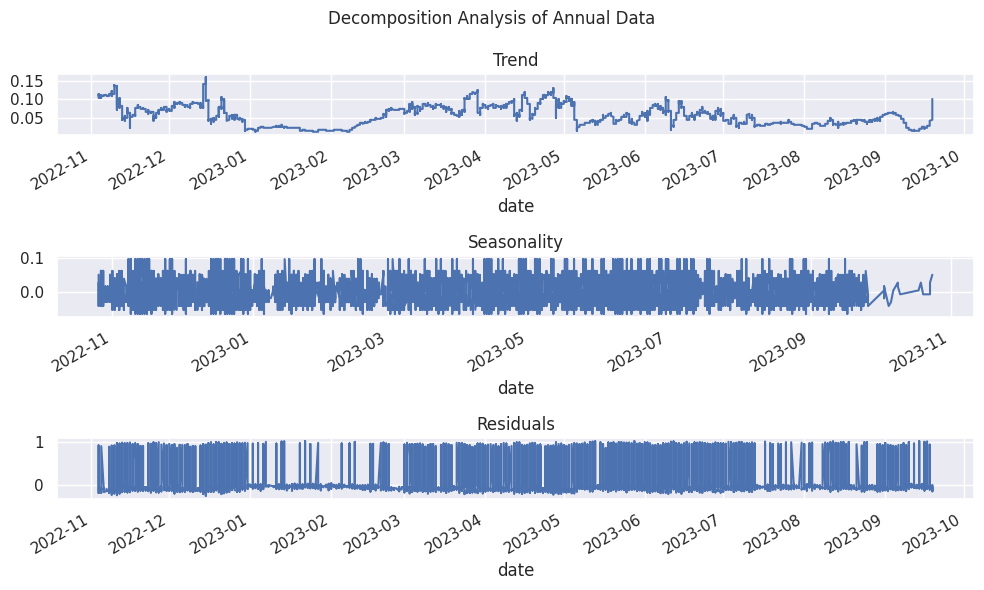

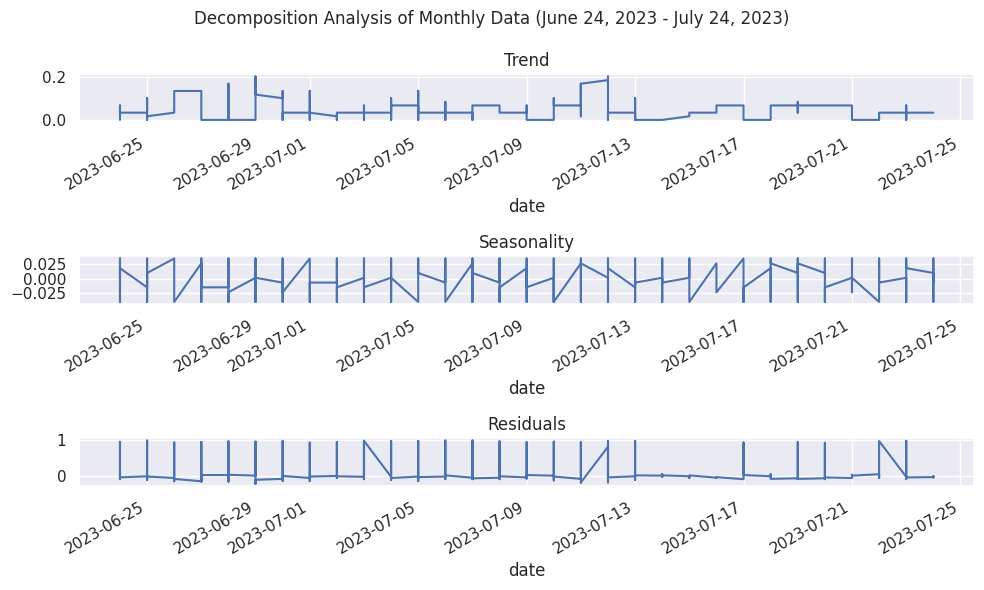

In [26]:
explorer_apparel.seasonality_and_stationarity(grouped_aprl, period_1=365, period_2=30)

### Gifts

Проведение теста Дики-Фуллера для проверки ряда на стационарность
adf:  -17.688799196702885
p-value:  3.5801169349813894e-30
Critical values:  {'1%': -3.4495033946549123, '5%': -2.8699787979596136, '10%': -2.5712658305164955}
ряд стационарен, единичных корней нет


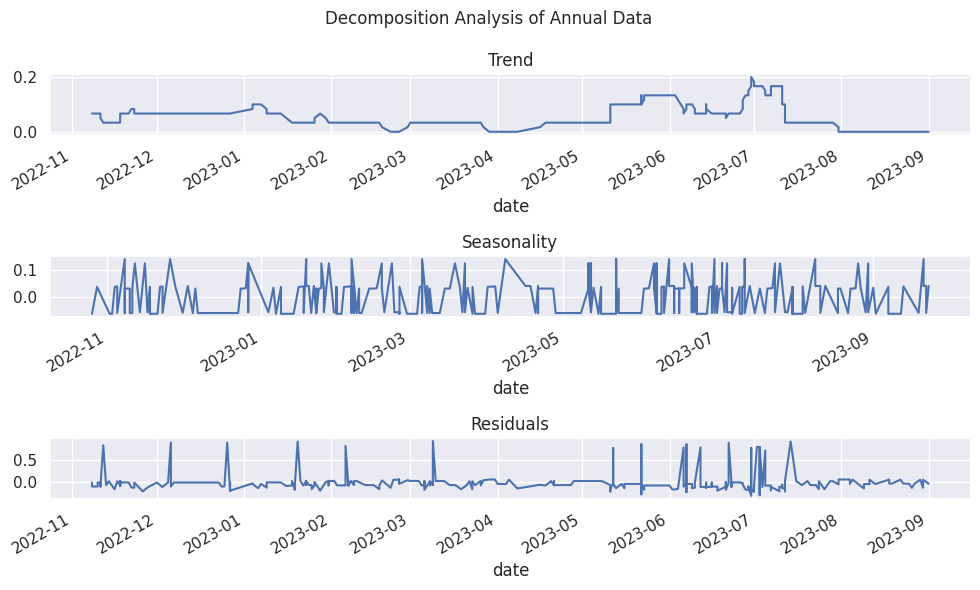

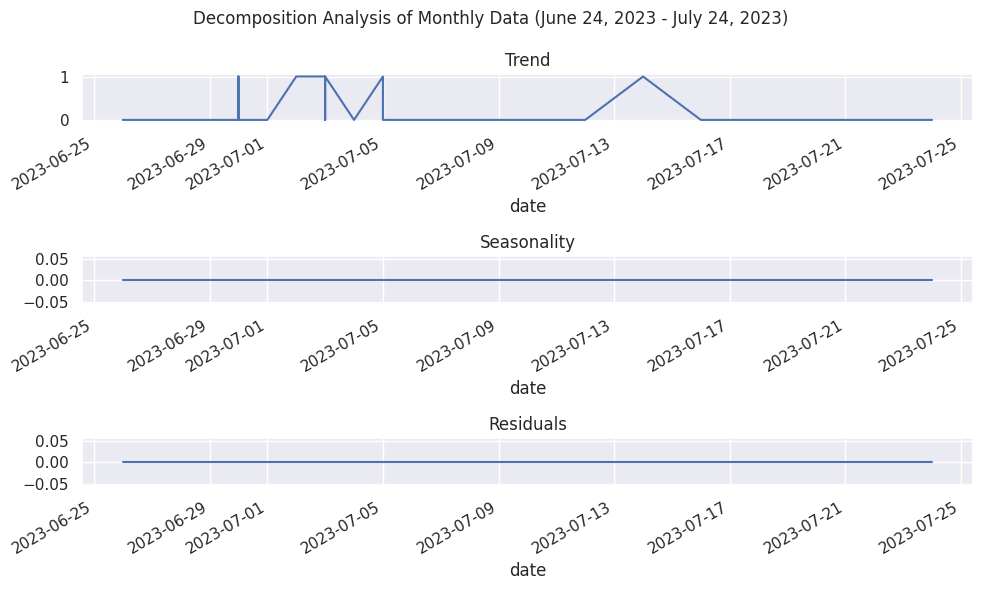

In [27]:
explorer_gifts.seasonality_and_stationarity(grouped_gft, period_1=30, period_2=1)

### Выводы и наблюдения
<br>По всем датасетам
- Сезонности не выявлено;
- трендов не выявлено;
- проведённый тест Дики-Фуллера позволяет предположить,
  <br>что предоставленные датасеты стационарны.

## Подготовка признаков к обучению моделей

### Marketplace

In [28]:
X_train_mp, X_test_mp, y_train_mp, y_test_mp, tscv_mp = explorer_marketplace.prepare_for_training(dataset=grouped_mp)

(19544, 6) (2172, 6) (19544,) (2172,)


### Apparel

In [29]:
X_train_apr, X_test_apr, y_train_apr, y_test_apr, tscv_apr = explorer_apparel.prepare_for_training(dataset=grouped_aprl)

(29154, 6) (3240, 6) (29154,) (3240,)


### Gifts

In [30]:
X_train_gf, X_test_gf, y_train_gf, y_test_gf, tscv_gf = explorer_gifts.prepare_for_training(dataset=grouped_gft)

(310, 6) (35, 6) (310,) (35,)


### Выводы и наблюдения
<br>По всем датасетам
- произведено масштабирование числовых признаков;
- произведено разделение данных на обучающий и тестовый наборы;
- создан объект `TimeSeriesSplit` для проведения кросс-валидации.

## Обучение моделей

In [31]:
X_train_mp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19544 entries, 2022-10-26 to 2023-09-14
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   quantity        19544 non-null  float64
 1   price           19544 non-null  float64
 2   cumulative_sum  19544 non-null  float64
 3   is_holiday      19544 non-null  float64
 4   message_id      19544 non-null  object 
 5   client_id       19544 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.0+ MB


In [32]:
import seaborn as sns
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_curve, recall_score, roc_auc_score, precision_score, confusion_matrix
from catboost import CatBoostClassifier, Pool

In [34]:
# all_forecasts = pd.DataFrame()

# # Группируйте данные по пользователю
# for user_id, user_data in X_train_mp.groupby('client_id'):
#     # Создайте модель Prophet
#     model = Prophet()
    
#     # Обучите модель на данных пользователя
#     model.fit(user_data[['ds', 'y']])
    
#     # Создайте DataFrame с будущими датами для прогноза
#     future = model.make_future_dataframe(periods=30)
    
#     # Сделайте прогноз для пользователя
#     forecast = model.predict(future)
    
#     # Добавьте прогноз для пользователя в общий DataFrame
#     forecast['client_id'] = user_id
#     all_forecasts = pd.concat([all_forecasts, forecast])

In [ ]:
# forecast['yhat']
# forecast.info()

In [ ]:
def modeling_pipeline(model_name, X_train, y_train, tscv):
    '''
  - на вход получает название модели, обучающие данные и объект TimeSerisSplit;
  - на выходе выводит на печать recall и precision, параметры модели и лучшую метрику;
  - визуализирует результаты обучения на диаграмме.
  '''
    if model_name == 'Baseline':
        model = LogisticRegression()
        scorers = {
            'recall': make_scorer(recall_score),
            'precision': make_scorer(precision_score)
        }
        param_grid = {'fit_intercept': [True, False]}
        grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring=scorers, refit='recall')
        grid_search.fit(X_train.drop(['message_id', 'client_id'], axis=1).values, y_train)
        y_pred = grid_search.predict(X_train.drop(['message_id', 'client_id'], axis=1).values)
        y_pred_proba = grid_search.predict_proba(X_train.drop(['message_id', 'client_id'], axis=1).values)[:, 1]
        print("Лучшие параметры GridSearch:", grid_search.best_params_)
        print("Лучшая оценка GridSearch:", abs(grid_search.best_score_))

    elif model_name == 'Prophet':
        model = Prophet()
        df = pd.DataFrame({'ds': X_train.index, 'y': y_train.values})
        model.fit(df)
        
        future = model.make_future_dataframe(periods=30)
        forecast = model.predict(future)
        # y_pred = forecast['yhat'].tail(len(y_train))
        # y_pred = forecast['yhat'][-len(y_train):]

        model.plot(forecast)
        plt.title("Прогноз модели")
        plt.ylabel("Количество")
        plt.xlabel("Период")
        plt.show()
                            
    elif model_name == 'CatBoost':
        model = CatBoostClassifier(random_state=RANDOM_STATE, eval_metric='AUC')  # text_features=['message_id'],
        model.fit(X_train.drop(['message_id', 'client_id'], axis=1).values, y_train, verbose=100)
        y_pred_proba = model.predict_proba(X_train.drop(['message_id', 'client_id'], axis=1).values)[:, 1]
        y_pred = model.predict(X_train.drop(['message_id', 'client_id'], axis=1).values)

    # Вычислите ROC-AUC, precision, recall
    roc_auc_value = roc_auc_score(y_train, y_pred_proba)
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)

    print("ROC-AUC:", roc_auc_value)
    print("Precision:", precision)
    print("Recall:", recall)

    # Визуализация кривой ROC
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
    sns.set_style('darkgrid')
    plt.plot(fpr, tpr, linewidth=1.5, label='ROC-AUC (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1.5, label='random_classifier')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.title('%s Receiver Operating Characteristic' % model_name, fontsize=12)
    plt.legend(loc='lower right')
    plt.show()

    return recall, precision, roc_auc_value, model

In [ ]:
recall_cb, precision_cb, roc_auc_cb, model_cb = (
    modeling_pipeline(model_name='CatBoost', X_train=X_train_mp, y_train=y_train_mp, tscv=tscv_mp)
)

In [ ]:
recall_baseline, precision_baseline, roc_auc_baseline, baseline = (
    modeling_pipeline(model_name='Baseline', X_train=X_train_mp, y_train=y_train_mp, tscv=tscv_mp)
)

## Выбор лучшей модели

In [ ]:
dict_sum = {'Baseline': [recall_baseline, precision_baseline, roc_auc_baseline]}#,
            # 'Catboost': [recall_cb, precision_cb, roc_auc_cb],
            # 'Prophet': [recall_prophet, precision_prophet, roc_auc_prophet]}
summary_data = (
    pd.DataFrame.from_dict(dict_sum,
                           orient='index',
                           columns=["recall",
                                    "precision",
                                    "roc-auc"])
    .reset_index()
    .rename(columns={'index': 'model'})
)
summary_data.sort_values('recall', ascending=False).reset_index(drop=True)

Сохранение зависимостей

In [ ]:
# !pip freeze > requirements.txt